In [14]:
import os
from pathlib import Path
import glob

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import mean_squared_error
from math import sqrt

from sewar.full_ref import uqi, psnr, rmse, ssim

import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
from sklearn.model_selection import train_test_split
np.random.seed(111)

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

### Load dataset

In [2]:
!ls dataset/

test          train         train_cleaned


In [3]:
input_dir  = Path('/Users/chinmay/Documents/Computer Vision/Project/dataset/')
train = input_dir / 'train'
train_cleaned = input_dir / 'train_cleaned'
test = input_dir / 'test'

In [4]:
train_images = sorted(os.listdir(train))
train_labels = sorted(os.listdir(train_cleaned))
test_images = sorted(os.listdir(test))

print("Total number of images in the training set: ", len(train_images))
print("Total number of cleaned images found: ", len(train_labels))
print("Total number of samples in the test set: ", len(test_images))

Total number of images in the training set:  144
Total number of cleaned images found:  144
Total number of samples in the test set:  72


### Visualize the dataset

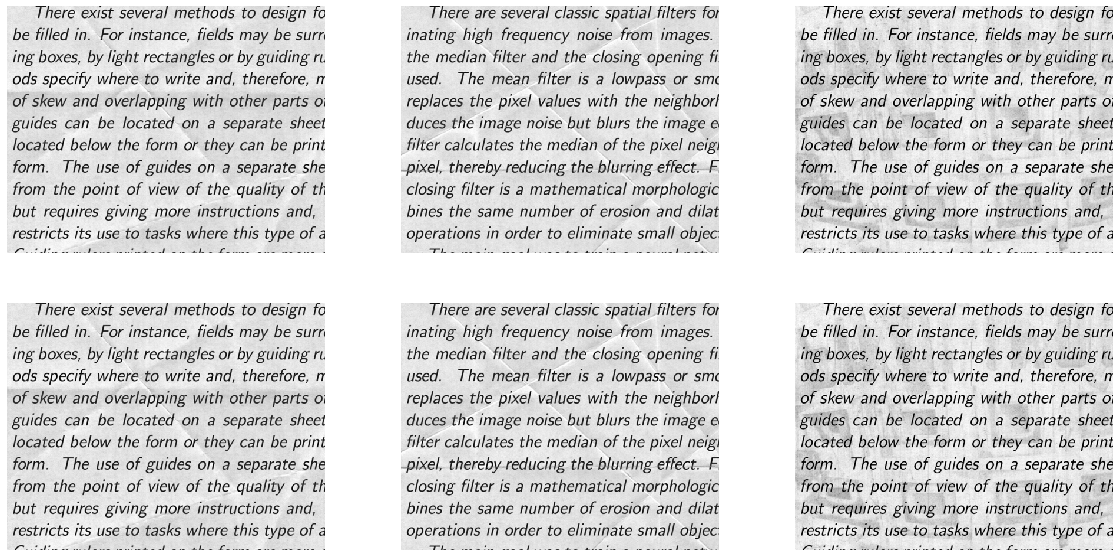

In [5]:
samples = train_images[:3] + train_labels[:3]

f, ax = plt.subplots(2, 3, figsize=(20,10))
for i, img in enumerate(samples):
    img = imread(train/img)
    ax[i//3, i%3].imshow(img, cmap='gray')
    ax[i//3, i%3].axis('off')
plt.show()    

### Build Autoencoder

In [6]:
def build_autoencoder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    # Encoder 
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    
    # Decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
    
    # Model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return autoencoder

In [7]:
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 420, 540, 1)       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 420, 540, 32)      320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 210, 270, 32)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 210, 270, 64)      18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 105, 135, 64)      0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 105, 135, 64)      36928     
_________________________________________________________________
upsample1 (UpSampling2D)     (None, 210, 270, 64)      0   

### Store the images as array in list

In [8]:
X = []
Y = []

for img in train_images:
    img = load_img(train / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)

for img in train_labels:
    img = load_img(train_cleaned / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)


X = np.array(X)
Y = np.array(Y)

print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)

/Users/chinmay/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Size of X :  (144, 420, 540, 1)
Size of Y :  (144, 420, 540, 1)


### Split the dataset into training and validation dataset

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=111)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)

Total number of training samples:  (129, 420, 540, 1)
Total number of validation samples:  (15, 420, 540, 1)


### Train the model with the image dataset

In [10]:
autoencoder.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_valid, y_valid))

Train on 129 samples, validate on 15 samples
Epoch 1/10
129/129 [==============================] - 109s 842ms/step - loss: 0.4185 - val_loss: 0.3602
Epoch 2/10
129/129 [==============================] - 106s 822ms/step - loss: 0.3423 - val_loss: 0.3257
Epoch 3/10
129/129 [==============================] - 106s 823ms/step - loss: 0.2832 - val_loss: 0.2539
Epoch 4/10
129/129 [==============================] - 106s 822ms/step - loss: 0.2406 - val_loss: 0.2368
Epoch 5/10
129/129 [==============================] - 106s 823ms/step - loss: 0.2226 - val_loss: 0.2209
Epoch 6/10
129/129 [==============================] - 106s 824ms/step - loss: 0.2021 - val_loss: 0.2030
Epoch 7/10
129/129 [==============================] - 106s 821ms/step - loss: 0.1887 - val_loss: 0.1918
Epoch 8/10
129/129 [==============================] - 106s 822ms/step - loss: 0.1780 - val_loss: 0.1915
Epoch 9/10
129/129 [==============================] - 107s 826ms/step - loss: 0.1721 - val_loss: 0.1789
Epoch 10/10
129/129

### Test the model with sample image data

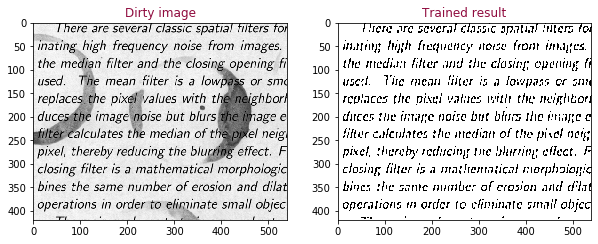

In [82]:
sample_test = load_img(train/ train_images[-1], grayscale=True, target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Get the predition
predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')

ax[0].set_title('Dirty image', color='#900c3f')
ax[1].set_title('Trained result', color='#900c3f')

plt.show()

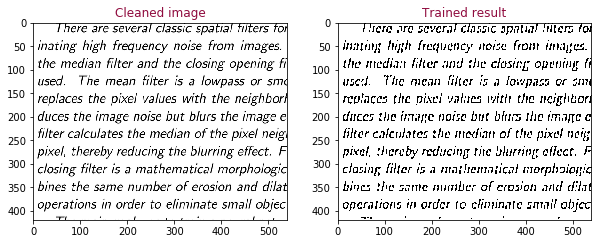

In [83]:
sample_test = load_img(train_cleaned/ train_images[-1], grayscale=True, target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Get the predition
predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')

ax[0].set_title('Cleaned image', color='#900c3f')
ax[1].set_title('Trained result', color='#900c3f')

plt.show()

## Compute uqi, psnr, rmse, ssim

In [84]:
sample = np.squeeze(sample_test)
print("Shape:", sample.shape)
print(type(sample))

Shape: (420, 540)
<class 'numpy.ndarray'>


In [85]:
print(predicted_label.shape)
print(type(predicted_label))

(420, 540)
<class 'numpy.ndarray'>


### Compute RMSE

In [86]:
print("RMSE:", rmse(sample, predicted_label))

RMSE: 234.2690120509222


### Computer UQI

In [87]:
print("UQI:", uqi(sample, predicted_label))

UQI: 6.0662959464855726e-05
